In [3]:
import torch

### Part 1

Реализуйте при помощи pyTorch функцию, которая возвращает сумму (x.sum()) элементов тензора X, строго превышающих значение limit, которое является входным значением алгоритма.



In [1]:
X = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
limit = int(input())

larger_than_limit_sum = X[X > limit].sum()

print(larger_than_limit_sum)

1
tensor(44)


### Part 2

Реализуйте расчет градиента для функции 
$ f(w) = \prod_{i,j}\ln\ln(w_{i,j}+7) $ в точке $ w = [[5,10],[1,2]] $

In [11]:
w = torch.tensor([[5.,10.],[1.,2.]], requires_grad=True)

function = (w + 7).log().log().prod()
function.backward()

print(w.grad)

tensor([[0.0201, 0.0109],
        [0.0449, 0.0351]])


Реализуйте градиентный спуск для той же функции $ f(w) = \prod_{i,j}\ln\ln(w_{i,j}+7) $ в точке $ w = [[5,10],[1,2]] $

шаг градиентного спуска $ \alpha=0.001 $

Чему будет равен $w^{t=500}$?

In [3]:
# x.data - tensor with requires_grad=False
# gradients are summing -> x.grad.zero_() (inplace)

w = torch.tensor([[5., 10.], [1., 2.]], requires_grad=True)
alpha = 0.001

for _ in range(500):
    # it's critical to calculate function inside the loop:
    function = (w + 7).log().log().prod()
    function.backward()
    w.data -=  alpha * w.grad
    w.grad.zero_()

print(w)

tensor([[4.9900, 9.9948],
        [0.9775, 1.9825]], requires_grad=True)


Перепишите пример, используя torch.optim.SGD

In [5]:
# optimizer.step() performes gradient descend step

w = torch.tensor([[5., 10.], [1., 2.]], requires_grad=True)
alpha = 0.001
optimizer =  torch.optim.SGD([w], lr=alpha)

for _ in range(500):
    # it's critical to calculate function inside the loop:
    function = (w + 7).log().log().prod()
    function.backward()
    optimizer.step()
    optimizer.zero_grad()

print(w)

tensor([[4.9900, 9.9948],
        [0.9775, 1.9825]], requires_grad=True)


### Part 3

Давайте попрактикуемся с SineNet:

1) Добавим еще один fc-слой

2) Заменим активацию между слоями на гиперболический тангенс

In [2]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x


sine_net = SineNet(int(input()))
sine_net.forward(torch.Tensor([1.]))

print(sine_net)

20
SineNet(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


Обучим нейронную сеть для задачи регрессии:

Возьмем более сложную функцию в качестве таргета: 

$$ y = 2^x\sin(2^{−x}) $$

Кроме того, мы хотим получить хорошую метрику MAE на валидации: 

$$ MAE = \frac{1}{l} \sum_{i=1}^{l}\lvert y\_pred_i - y\_target_i \rvert $$

тогда как знакомая нам MSE выглядит как 

$$ MSE = \frac{1}{l} \sum_{i=1}^{l}(y\_pred_i - y\_target_i)^2 $$

Получите метрику не хуже 0.03

Что можно варьировать: 

1) Архитектуру сети

2) loss-функцию

3) lr оптимизатора

4) Количество эпох в обучении


In [33]:
import torch

num_epoches = 1500
n_hidden = 50
learning_rate = 0.1

def target_function(x):
    return 2**x * torch.sin(2**-x)

# для создания нейронной сети нужно отнаследоваться от torch.nn.Module
class RegressionNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

net = RegressionNet(n_hidden)

# ------Dataset preparation start--------:
x_train =  torch.linspace(-10, 5, 100)
y_train = target_function(x_train)
noise = torch.randn(y_train.shape) / 20.
y_train = y_train + noise

# unsqueeze_ -> строка превращается в столбец
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

x_validation = torch.linspace(-10, 5, 100)
y_validation = target_function(x_validation)
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1)
# ------Dataset preparation end--------:

# net.paramerers() - веса сети, которые надо передать в оптимизатор, чтобы он их менял
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

def loss(pred, target):
    return ((pred - target) ** 2).mean()

# Эпоха - итерация обучения на всем датасете
for epoch_index in range(num_epoches):
    optimizer.zero_grad() # 1 - зануляем градиенты (для библиотеки PyTorch, иначе градиенты складываются)

    y_pred = net.forward(x_train) # 2 - вычисляем результат
    loss_value = loss(y_pred, y_train) # 3 - считаем лосс, который помнит, как он был посчитан с помощью весов
    loss_value.backward() # 4 - считаем градиенты для лосса
    optimizer.step() # 5 - пересчитываем веса на основе вычисленных градиентов для уменьшения лосса

def metric(pred, target):
    return (pred - target).abs().mean()

print(metric(net.forward(x_validation), y_validation).item())

0.017926551401615143


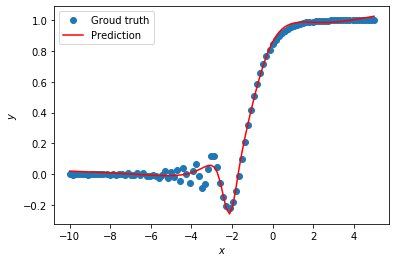

In [34]:
import matplotlib.pyplot as plt

def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), '-', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')


predict(net, x_validation, y_validation)

Фиксирование seed не гарантирует, что код будет одинаково выполняться на разных компьютерах. Но на одной и той же машине вы будете получать одинаковые результаты, перезапуская один и тот же скрипт.

Например, функция random.randint(start, end) отдает случайное целое число в диапазоне от start, end (включительно). Запуская скрипт, состоящий из вызова этой функции, вы будете получать разные ответы. 

В этом задании вам нужно подобрать seed, чтобы функция random.randint(0, 10) выдала число 5

PS: надо понимать, что фиксирование random seed не приведет к тому, что повторный вызов random.randint(0, 10) внутри того же скрипта снова даст 5. 

In [9]:
import random
random.seed(7)
print(random.randint(0, 10))

5


## Part 4

Как было сказано в предыдущем уроке, полносвязный слой может быть представлен как матричное умножение матрицы входов (X) и матрицы весов нейронов слоя (W), плюс вектор bias'ов слоя (b). 

В документации к классу torch.nn.Linear (полносвязному слою) написано следующее: Applies a linear transformation to the incoming data: 
$$ y=xA^T+b $$ $А$ здесь – это то, как PyTorch хранит веса слоя. Но чтобы эта матрица совпала с W из предыдущего урока, нужно её сперва транспонировать.

Давайте реализуем функциональность torch.nn.Linear и сверим с оригиналом!

Пусть у нас будет 1 объект x на входе с двумя компонентами. Его мы передадим в полносвязный слой с 3-мя нейронами и получим, соотсветственно, 3 выхода. После напишем эту же функциональность с помощью матричного умножения. 

In [24]:
# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)

# Попробуем теперь получить аналогичные выходы с помощью матричного перемножения:
# fc_out_alternative = x @ w.T + b

fc_out_alternative = x @ w.transpose(-1, -2) + b

# Проверка осуществляется автоматически вызовом функции
print(fc_out == fc_out_alternative)

tensor([[True, True, True]])


В предыдущем шаге мы написали функцию, эмулирующую fc-слой. Проверим, что по ней правильно считается градиент. 

Функцию backward() в PyTorch можно посчитать только от скалярной функции (выход из такой функции – одно число). Это логично, так как loss-функция выдает всегда одно число. Но fc-слой, который мы проэмулировали, имел 3 выхода. Предлагаем их просуммировать, чтобы получить в итоге скалярную функцию. Заметим, впрочем, что можно было бы выбрать любую агрегирующую операцию, например умножение.

Дополните код так, чтобы градиент по весам и смещениям (bias) совпадал с аналогичным градиентом в вашей фунции.

Чем обусловлен полученный градиент? Изменится ли он, если мы подадим другие входы или другую инициализацию весов?

In [25]:
# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)
# Просуммируем выход fc-слоя, чтобы получить скаляр:
fc_out_summed = fc_out.sum()

# Посчитаем градиенты формулы fc_out_summed:
fc_out_summed.backward()
weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

# Ok, теперь воспроизведем вычисления выше но без fc-слоя:
# Проставим, что у "w" и "b" нужно вычислять градиенты (для fc-слоя это произошло автоматически):
w.requires_grad_(True)
b.requires_grad_(True)

# Получим выход нашей формулы:
our_formula = (x @ w.transpose(-1, -2) + b).sum() # SUM{x * w^T + b}

# Сделайте backward для нашей формулы:
our_formula.backward()

# Проверка осуществляется автоматически, вызовом функций:
print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)

fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])


## Part 5

На этом уроке мы с вами реализуем прямой проход сверточного слоя, обратный проход и расчет производных мы трогать не будем.

Вспомним как работает сверточный слой:

1) на вход подается массив изображений, еще он называется батчем

2) к каждому изображению по границам добавляются нули

3) по каждому изображению "скользит" каждый из фильтров сверточного слоя

Давайте начнем с разминки - реализуем функцию, добавляющую padding.

Пусть у нас есть батч input_images из двух изображений с тремя каналами (RGB). Размер изображений пусть будет 3*3. Вспомним, что вход сверточного слоя имеет следующую размерность:

* размер батча

* число каналов

* высота

* ширина

В рассматриваемом случае размерность входа (2, 3, 3, 3).

Если мы добавим вокруг каждого изображения отступ из одного нуля, то размер каждого изображений станет 3+2*1 = 5 пикселей в ширину и 5 в высоту соответственно (добавляем по одному нулю с каждой стороны изображения).

Напишите любую работающую реализацию.

In [21]:
import torch

# Создаем входной массив из двух изображений RGB 3*3
input_images = torch.tensor(
      [[[[0,  1,  2],
         [3,  4,  5],
         [6,  7,  8]],

        [[9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]],


       [[[27, 28, 29],
         [30, 31, 32],
         [33, 34, 35]],

        [[36, 37, 38],
         [39, 40, 41],
         [42, 43, 44]],

        [[45, 46, 47],
         [48, 49, 50],
         [51, 52, 53]]]])


def get_padding2d(input_images):
    # добавить нулей с четырех сторон каждого изображения
    shape = input_images.shape
    padded_images = torch.zeros((shape[0],shape[1],shape[2]+2,shape[3]+2))
    for i in range(shape[0]):
        padded_images[i][:,1:-1,1:-1] = input_images[i]
    return padded_images.float()


correct_padded_images = torch.tensor(
       [[[[0.,  0.,  0.,  0.,  0.],
          [0.,  0.,  1.,  2.,  0.],
          [0.,  3.,  4.,  5.,  0.],
          [0.,  6.,  7.,  8.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0.,  9., 10., 11.,  0.],
          [0., 12., 13., 14.,  0.],
          [0., 15., 16., 17.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0., 18., 19., 20.,  0.],
          [0., 21., 22., 23.,  0.],
          [0., 24., 25., 26.,  0.],
          [0.,  0.,  0.,  0.,  0.]]],


        [[[0.,  0.,  0.,  0.,  0.],
          [0., 27., 28., 29.,  0.],
          [0., 30., 31., 32.,  0.],
          [0., 33., 34., 35.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0., 36., 37., 38.,  0.],
          [0., 39., 40., 41.,  0.],
          [0., 42., 43., 44.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0., 45., 46., 47.,  0.],
          [0., 48., 49., 50.,  0.],
          [0., 51., 52., 53.,  0.],
          [0.,  0.,  0.,  0.,  0.]]]])

# Проверка происходит автоматически вызовом следующего кода
print(torch.allclose(get_padding2d(input_images), correct_padded_images))

True


In [11]:
a = torch.zeros((2,3,5,5))
b = torch.ones((2,3,3,3))

In [12]:
a.shape[2], a.shape[3]

(5, 5)

In [14]:
for i in range(a.shape[0]):
    print(a[i][:,1:-1,1:-1])
    a[i][:,1:-1,1:-1] = b[i]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])


In [15]:
a

tensor([[[[0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.]]]])

На этом шаге детально рассмотрим из чего состоит сверточный слой.

Сверточный слой это массив фильтров.

Каждый фильтр имеет следующую размерность:

* число слоев во входном изображении (для RGB это 3)

* высота фильтра

* ширина фильтра

В ядре (кернеле) все фильтры имеют одинаковые размерность, поэтому ширину и высоту фильтров называют шириной и высотой ядра. Чаще всего ширина ядра равна высоте ядра, в таком случае их называют размером ядра (kernel_size).

Также слой имеет такие параметры:

* padding - на какое количество пикселей увеличивать входное изображение с каждой стороны.

* stride - на сколько пикселей смещается фильтр при вычислении свертки

 
Попробуйте самостоятельно вывести формулу размерности выхода сверточного слоя, зная параметры входа и ядра. 

Правильность формулы проверьте, сравнив ее с формулой из документации.


Чтобы убедиться в правильности вашей формулы, напишите функцию, принимающую на вход:

* входную размерность (число изображений в батче * число слоев в одном изображении * высота изображения * ширина изображения)

* количество фильтров

* размер фильтров (считаем, что высота совпадает с шириной)

* padding

* stride



In [9]:
import numpy as np


def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
    out_shape = np.full(4, 0)
    out_shape[0] = input_matrix_shape[0]
    out_shape[1] = out_channels
    out_shape[2] = np.floor((input_matrix_shape[2] + 2 * padding - (kernel_size - 1) - 1) / stride + 1)
    out_shape[3] = np.floor((input_matrix_shape[3] + 2 * padding - (kernel_size - 1) - 1) / stride + 1)

    return out_shape

print(np.array_equal(
    calc_out_shape(input_matrix_shape=[2, 3, 10, 10],
                   out_channels=10,
                   kernel_size=3,
                   stride=1,
                   padding=0),
    [2, 10, 8, 8]))

print(calc_out_shape(input_matrix_shape=[2, 3, 10, 10],
                   out_channels=10,
                   kernel_size=3,
                   stride=1,
                   padding=0))

True
[ 2 10  8  8]


Переиспользуем код с предыдущего шага для проверки своей реализации сверточного слоя.

Рассмотрим свертку батча из одного однослойного изображения 3 * 3 с ядром из одного фильтра 2 * 2, stride = 1, то есть, на выходе должна получиться одна матрица 2 * 2. Строго записанная размерность выхода равна (1 - изображений в батче, 1 - количество фильтров в ядре, 2 - высота матрицы выхода, 2 - ширина матрицы выхода)

<img src="img1.png" width=50%/>

На каждой итерации цикла фильтр умножается попиксельно на часть изображения, а потом 4 получившиеся числа складываются - получается один пиксель выхода.

Требуемое количество итераций для данного случая - 4, так как может быть 2 положения ядра и 2 по вертикали, общее число итераций - произведение количеств положений, то есть в данном случае 2 * 2 = 4.

Давайте перейдем от простого случая к общему.

Если бы изображение было многослойным, например трехслойное - RGB, значит, фильтры в ядре тоже должны быть трехслойные. Каждый слой фильтра попиксельно умножается на соответствующий слой исходного изображения. То есть в данном случае после умножения получилось бы 4 * 3 = 12 произведений, результаты которых складываются, и получается значение выходного пикселя.

Если бы фильтров в ядре было больше одного, то добавился бы внешний цикл по фильтрам, внутри которого мы считаем свертку для каждого фильтра.

Если бы во входном батче было более 1 изображения, то добавился бы еще один внешний цикл по изображениям в батче.

Напоминание: во всех шагах этого урока мы считаем bias в сверточных слоях нулевым.

На этом шаге требуется реализовать сверточный слой через циклы.

Обратите внимание, что в коде рассматривается общий случай - батч на входе не обязательно состоит из одного изображения, в ядре несколько слоев.

In [1]:
import torch
from abc import ABC, abstractmethod

def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
    batch_size, channels_count, input_height, input_width = input_matrix_shape
    output_height = (input_height + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    output_width = (input_width + 2 * padding - (kernel_size - 1) - 1) // stride + 1

    return batch_size, out_channels, output_height, output_width


class ABCConv2d(ABC):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def set_kernel(self, kernel):
        self.kernel = kernel

    @abstractmethod
    def __call__(self, input_tensor):
        pass


class Conv2d(ABCConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                      stride, padding=0, bias=False)

    def set_kernel(self, kernel):
        self.conv2d.weight.data = kernel

    def __call__(self, input_tensor):
        return self.conv2d(input_tensor)


def create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_matrix):
    out_channels = kernel.shape[0]
    in_channels = kernel.shape[1]
    kernel_size = kernel.shape[2]

    layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride)
    layer.set_kernel(kernel)

    return layer(input_matrix)


def test_conv2d_layer(conv2d_layer_class, batch_size=2,
                      input_height=4, input_width=4, stride=2):
    kernel = torch.tensor(
                      [[[[0., 1, 0],
                         [1,  2, 1],
                         [0,  1, 0]],

                        [[1, 2, 1],
                         [0, 3, 3],
                         [0, 1, 10]],

                        [[10, 11, 12],
                         [13, 14, 15],
                         [16, 17, 18]]]])

    in_channels = kernel.shape[1]

    input_tensor = torch.arange(0, batch_size * in_channels *
                                input_height * input_width,
                                out=torch.FloatTensor()) \
        .reshape(batch_size, in_channels, input_height, input_width)

    custom_conv2d_out = create_and_call_conv2d_layer(
        conv2d_layer_class, stride, kernel, input_tensor)
    conv2d_out = create_and_call_conv2d_layer(
        Conv2d, stride, kernel, input_tensor)
    print(custom_conv2d_out, conv2d_out)

    return torch.allclose(custom_conv2d_out, conv2d_out) \
             and (custom_conv2d_out.shape == conv2d_out.shape)


# Сверточный слой через циклы.
class Conv2dLoop(ABCConv2d):
    def __call__(self, input_tensor):
        batch_size, out_channels, output_height, output_width = calc_out_shape(
        input_tensor.shape, self.out_channels, self.kernel_size, self.stride, 0)
        output_tensor = torch.zeros((batch_size, out_channels, output_height, output_width), requires_grad=True)
        for batch_num in range(batch_size):
            for out_channel in range(out_channels):
                for in_channel in range(self.in_channels):
                    for width in range(output_width):
                        for height in range(output_height):
                            window = input_tensor[batch_num][:,height*self.stride:height*self.stride+self.kernel_size,
                                                                         width*self.stride:width*self.stride+self.kernel_size]
                            output_tensor[batch_num, out_channel, height, width] = (window * self.kernel[out_channel]).sum()

        return output_tensor

# Корректность реализации определится в сравнии со стандартным слоем из pytorch.
# Проверка происходит автоматически вызовом следующего кода

print(test_conv2d_layer(Conv2dLoop))

tensor([[[[ 5252.]]],


        [[[12596.]]]], grad_fn=<CopySlices>) tensor([[[[ 5252.]]],


        [[[12596.]]]], grad_fn=<MkldnnConvolutionBackward>)
True


Переиспользуем код с третьего шага для проверки своей реализации сверточного слоя.

Реализация через циклы очень неэффективна по производительности. Есть целых два способа сделать то же самое с помощью матричного умножения. 

На этом шаге будет реализация первым из них.

 

Рассмотрим свертку одного одноканального изображения размером 4 * 4 пикселя (значения пикселей обозначены через X).

Сворачивать будем с ядром из одного фильтра размером 3 * 3, веса обозначены через W.

Для простоты примем stride = 1.

Тогда выход Y будет иметь размерность 1 * 1 * 2 * 2 (в данном случае на входе одно изображение - это первая единица в размерности, в ядре один фильтр - это вторая единица в размерности выхода).

<img src="img2.png"/>

Оказывается, выход свертки можно получить умножением матриц, как показано ниже.

<img src="img3.svg"/>

Рекомендуем убедиться в этом, перемножив матрицы на листочке.

Давайте перейдем от простого случая к общему:

* Если фильтров в ядре больше одного. Заметим, что для каждого фильтра, матрица W’ будет умножаться на один и тот же вектор изображения. Значит, можно сконкатенировать матрицы фильтров ядра по вертикали и за одно умножение получить ответ для всех фильтров.

<img src="img4.svg"/>

* Если на входе более одного изображения: заметим, что матрица W’ одинакова для всех изображений батча, то есть, можно каждое изображение вначале вытянуть в столбец, а затем эти столбцы для всех изображений батча сконкатенировать по горизонтали.

<img src="img5.svg"/>

* Если в изображении больше одного слоя, вначале выполним преобразования входа и ядра для каждого слоя, а затем сконкатенируем: вектора разных слоев входа в один большой вектор, а матрицы ядра соответственно в одну длинную матрицу. И мы получим сложение от выходов по слоям в процессе перемножения матриц.

<img src="img6.png"/>

То есть даже в самом общем случае мы за одно умножение матриц можем получить ответ.

Но рассчитанный таким способом выход не совпадает по размерности с выходом стандартного слоя из PyTorch - нужно изменить размерность.

 

В коде уже реализовано:

* преобразование входного батча изображений

* умножение матрицы ядра на матрицу входа

* преобразование ответа

Напоминание: во всех шагах этого урока мы считаем bias в сверточных слоях нулевым.

Вам осталось реализовать преобразование ядра в описанный выше формат.

Обратите внимание, что в коде рассматривается общий случай - вход состоит из нескольких многослойных изображений, в ядре несколько слоев.

In [12]:
def test_conv2d_layer(conv2d_layer_class, batch_size=2,
                      input_height=4, input_width=4, stride=2):
    kernel = torch.tensor(
                      [[[[0., 1, 0],
                         [1,  2, 1],
                         [0,  1, 0]],

                        [[1, 2, 1],
                         [0, 3, 3],
                         [0, 1, 10]],

                        [[10, 11, 12],
                         [13, 14, 15],
                         [16, 17, 18]]]])

    in_channels = kernel.shape[1]

    input_tensor = torch.arange(0, batch_size * in_channels *
                                input_height * input_width,
                                out=torch.FloatTensor()) \
        .reshape(batch_size, in_channels, input_height, input_width)

    custom_conv2d_out = create_and_call_conv2d_layer(
        conv2d_layer_class, stride, kernel, input_tensor)
    conv2d_out = create_and_call_conv2d_layer(
        Conv2d, stride, kernel, input_tensor)

    return torch.allclose(custom_conv2d_out, conv2d_out) \
             and (custom_conv2d_out.shape == conv2d_out.shape)


class Conv2dMatrix(ABCConv2d):
    # Функция преобразование кернела в матрицу нужного вида.
    def _unsqueeze_kernel(self, torch_input, output_height, output_width):
        kernel_unsqueezed = 0
        return kernel_unsqueezed

    def __call__(self, torch_input):
        batch_size, out_channels, output_height, output_width\
            = calc_out_shape(
                input_matrix_shape=torch_input.shape,
                out_channels=self.kernel.shape[0],
                kernel_size=self.kernel.shape[2],
                stride=self.stride,
                padding=0)
        print(output_height, output_width)
        kernel_unsqueezed = self._unsqueeze_kernel(torch_input, output_height, output_width)
        result = kernel_unsqueezed @ torch_input.view((batch_size, -1)).permute(1, 0)
        return result.permute(1, 0).view((batch_size, self.out_channels,
                                          output_height, output_width))

# Проверка происходит автоматически вызовом следующего кода
print(test_conv2d_layer(Conv2dMatrix))

1 1


TypeError: unsupported operand type(s) for @: 'int' and 'Tensor'

In [9]:
k = torch.tensor(
                      [[[[0., 1, 0],
                         [1,  2, 1],
                         [0,  1, 0]],

                        [[1, 2, 1],
                         [0, 3, 3],
                         [0, 1, 10]],

                        [[10, 11, 12],
                         [13, 14, 15],
                         [16, 17, 18]]]])
k.view(-1)

tensor([ 0.,  1.,  0.,  1.,  2.,  1.,  0.,  1.,  0.,  1.,  2.,  1.,  0.,  3.,
         3.,  0.,  1., 10., 10., 11., 12., 13., 14., 15., 16., 17., 18.])

In [10]:
torch.reshape(k, (1, 1))

tensor([[[[ 0.,  1.,  0.],
          [ 1.,  2.,  1.],
          [ 0.,  1.,  0.]],

         [[ 1.,  2.,  1.],
          [ 0.,  3.,  3.],
          [ 0.,  1., 10.]],

         [[10., 11., 12.],
          [13., 14., 15.],
          [16., 17., 18.]]]])

In [1]:
import torch

N = 4
C = 3
C_out = 10
H = 8
W = 16

x = torch.ones((N, C, H, W))

# torch.Size([4, 10, 8, 16])
out1 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=1)(x)
print(out1.shape)

# torch.Size([4, 10, 8, 16])
out2 = torch.nn.Conv2d(C, C_out, kernel_size=(5, 5), padding=2)(x)
print(out2.shape)

# torch.Size([4, 10, 8, 16])
out3 = torch.nn.Conv2d(C, C_out, kernel_size=(7, 7), padding=3)(x)
print(out3.shape)

# torch.Size([4, 10, 8, 16])
out4 = torch.nn.Conv2d(C, C_out, kernel_size=(9, 9), padding=4)(x)
print(out4.shape)

# torch.Size([4, 10, 8, 16])
out5 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 5), padding=(1, 2))(x)
print(out5.shape)

# torch.Size([4, 10, 22, 30])
out6 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=8)(x)
print(out6.shape)

# torch.Size([4, 10, 7, 15])
out7 = torch.nn.Conv2d(C, C_out, kernel_size=(4, 4), padding=1)(x)
print(out7.shape)

# torch.Size([4, 10, 9, 17])
out8 = torch.nn.Conv2d(C, C_out, kernel_size=(2, 2), padding=1)(x)
print(out8.shape)

torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 22, 30])
torch.Size([4, 10, 7, 15])
torch.Size([4, 10, 9, 17])


## Part 6

В этом уроке мы детально изучим слои нормализации.

 

Самая популярная версия слоя нормализации - слой нормализации "по батчу" (batch-norm слой).

Рассмотрим его работу в наиболее простом случае, когда на вход подается батч из одномерных векторов:

* На вход подается батч одномерных векторов:

<img src='01.PNG'/>

где j индекс вектора внутри батча, i - номер компоненты.

Для текущего батча:

* По каждой компоненте входа вычисляются мат.ожидание и дисперсия:

<img src='02.PNG'/>

<img src='03.PNG'/>

* Вход нормируется по формуле: 

<img src='04.PNG'/>

Эпсилон необходим для случая нулевой дисперсии.

* Нормированный вход преобразуется следующим образом:

<img src='05.PNG'/>

Где Гамма и Бета - обучаемые параметры слоя. Обратите внимание, Гамма и Бета - вектора такой же длины, как инстансы входа.

Их можно фиксировать, например, простейший случай - Бета принимается равным нулевому вектору, Гамма - вектору из единиц. 

Если же взять Гамму равным знаменателю дроби из формулы для Z, а Бету равным мат.ожиданию, то слой вернет входной тензор без изменений. То есть, слой будет эквивалентен тождественной функции.

Таким образом, параметры Бета и Гамма позволяют не терять входящию в слой информацию, и одновременно с этим, батч-норм слой нормализует вход. Последнее ускоряет сходимость параметров сети, а в некоторых случаях без нормализации добиться сходимости сети крайне сложно.

Итоговая формула преобразования входа: 

<img src='06.PNG'/>

В этом уроке мы будем двигаться по следующему плану:

1) Вначале реализуем train-этап батч-нормализации для батча из одномерных векторов с нулевым Бета и единичным Гамма.

2) Затем добавим возможность задания параметров Бета и Гамма.

3) После этого добавим eval-этап использования слоя.

4) И последним шагом по батч-нормализации реализуем train-этап слоя батч-нормализации для батча из многоканальных двумерных тензоров с нулевым Бета и единичным Гамма.

5) После батч-нормализации вас ждут шаги по другим видам нормализации.

### Tasks

В данном шаге вам требуется реализовать функцию батч-нормализации без использования стандартной функции со следующими упрощениями:

* Параметр Бета принимается равным 0.

* Параметр Гамма принимается равным 1.

* Функция должна корректно работать только на этапе обучения.

* Вход имеет размерность число элементов в батче * длина каждого инстанса.


In [23]:
import numpy as np
import torch
import torch.nn as nn

def custom_batch_norm1d(input_tensor, eps):
    std, mean = torch.std_mean(input_tensor, dim=0, unbiased=False)
    normed_tensor = (input_tensor - mean) / (std**2 + eps)** 0.5 # y_i = z_i
    return normed_tensor


input_tensor = torch.Tensor([[0.0, 0, 1, 0, 2], [0, 1, 1, 0, 10]])
batch_norm = nn.BatchNorm1d(input_tensor.shape[1], affine=False)

all_correct = True
for eps_power in range(10):
    eps = np.power(10., -eps_power)
    batch_norm.eps = eps
    batch_norm_out = batch_norm(input_tensor)
    custom_batch_norm_out = custom_batch_norm1d(input_tensor, eps)

    all_correct &= torch.allclose(batch_norm_out, custom_batch_norm_out)
    all_correct &= batch_norm_out.shape == custom_batch_norm_out.shape
print(all_correct)

True


Немного обобщим функцию с предыдущего шага - добавим возможность задавать параметры Бета и Гамма.

На данном шаге вам требуется реализовать функцию батч-нормализации без использования стандартной функции со следующими упрощениями:

* Функция должна корректно работать только на этапе обучения.

* Вход имеет размерность число элементов в батче * длина каждого инстанса.

In [25]:
import torch
import torch.nn as nn

input_size = 7
batch_size = 5
input_tensor = torch.randn(batch_size, input_size, dtype=torch.float)

eps = 1e-3

def custom_batch_norm1d(input_tensor, weight, bias, eps):
    std, mean = torch.std_mean(input_tensor, dim=0, unbiased=False)
    normed_tensor = weight * (input_tensor - mean) / (std**2 + eps)** 0.5 + bias
    return normed_tensor

batch_norm = nn.BatchNorm1d(input_size, eps=eps)
batch_norm.bias.data = torch.randn(input_size, dtype=torch.float)
batch_norm.weight.data = torch.randn(input_size, dtype=torch.float)
batch_norm_out = batch_norm(input_tensor)
custom_batch_norm_out = custom_batch_norm1d(input_tensor, batch_norm.weight.data, batch_norm.bias.data, eps)
print(torch.allclose(batch_norm_out, custom_batch_norm_out) \
      and batch_norm_out.shape == custom_batch_norm_out.shape)

True


Избавимся еще от одного упрощения - реализуем работу слоя батч-нормализации на этапе предсказания.

На этом этапе вместо статистик по батчу будем использовать экспоненциально сглаженные статистики из истории обучения слоя.

В данном шаге вам требуется реализовать полноценный класс батч-нормализации без использования стандартной функции, принимающий на вход двумерный тензор. Осторожно, расчёт дисперсии ведётся по смещенной выборке, а расчет скользящего среднего по несмещенной.

In [20]:
import torch
import torch.nn as nn


input_size = 3
batch_size = 5
eps = 1e-1


class CustomBatchNorm1d:
    def __init__(self, weight, bias, eps, momentum):
        self.weight = weight
        self.bias = bias
        self.eps = eps
        self.momentum = momentum
        input_size = weight.shape[0]
        self.running_mean = torch.zeros(input_size)
        self.running_var = torch.ones(input_size)
        self.predict = False

    def __call__(self, input_tensor):
        
        if self.predict:
            normed_tensor = self.weight * (input_tensor \
                                           - self.running_mean) / (self.running_var + self.eps)** 0.5 + self.bias
            return normed_tensor
        batch_size = input_tensor.shape[0]
        var = torch.var(input_tensor, dim=0, unbiased=False)
        mean = torch.mean(input_tensor, dim=0)
        self.running_mean = (1 - self.momentum) * mean + self.momentum * self.running_mean
        self.running_var = (1 - self.momentum) * var * batch_size / (batch_size - 1) \
            + self.momentum * self.running_var
        normed_tensor = self.weight * (input_tensor \
                                       - mean) / (var + self.eps)** 0.5 + self.bias
        return normed_tensor

    def eval(self):
        self.predict = True


batch_norm = nn.BatchNorm1d(input_size, eps=eps)
batch_norm.bias.data = torch.randn(input_size, dtype=torch.float)
batch_norm.weight.data = torch.randn(input_size, dtype=torch.float)
batch_norm.momentum = 0.5

custom_batch_norm1d = CustomBatchNorm1d(batch_norm.weight.data,
                                        batch_norm.bias.data, eps, batch_norm.momentum)

all_correct = True

for i in range(8):
    torch_input = torch.randn(batch_size, input_size, dtype=torch.float)
    norm_output = batch_norm(torch_input)
    custom_output = custom_batch_norm1d(torch_input)
    all_correct &= torch.allclose(norm_output, custom_output) \
        and norm_output.shape == custom_output.shape
print(all_correct)

batch_norm.eval()
custom_batch_norm1d.eval()

for i in range(8):
    torch_input = torch.randn(batch_size, input_size, dtype=torch.float)
    norm_output = batch_norm(torch_input)
    custom_output = custom_batch_norm1d(torch_input)
    all_correct &= torch.allclose(norm_output, custom_output) \
        and norm_output.shape == custom_output.shape
print(all_correct)

True
True


Как вы могли убедиться, реализовать батч-норм слой на этапе предсказания не так просто, поэтому в дальнейших шагах этого урока мы больше не будем требовать реализовать эту часть.

Слой батч-нормализации существует для входа любой размерности.

В данном шаге рассмотрим его для входа из многоканальных двумерных тензоров, например, изображений.

Если вытянуть каждый канал картинки в вектор, то вход будет трехмерным:

* количество картинок в батче

* число каналов в каждой картинке

* число пикселей в картинке

Процесс нормализации:

1) Вход разбивается на срезы, параллельные синей части. То есть, каждый срез - это все пиксели всех изображений по одному из каналов.

2) Для каждого среза считаются мат. ожидание и дисперсия.

3) Каждый срез нормализуется независимо.
 

На данном шаге вам предлагается реализовать батч-норм слой для четырехмерного входа (например, батч из многоканальных двумерных картинок) без использования стандартной реализации со следующими упрощениями:

* Параметр Бета = 0.

* Параметр Гамма = 1.

* Функция должна корректно работать только на этапе обучения.

In [13]:
import torch
import torch.nn as nn

eps = 1e-3

input_channels = 3
batch_size = 3
height = 10
width = 10

batch_norm_2d = nn.BatchNorm2d(input_channels, affine=False, eps=eps)

input_tensor = torch.randn(batch_size, input_channels, height, width, dtype=torch.float)


def custom_batch_norm2d(input_tensor, eps):
    input_channels = input_tensor.shape[1]
    input_tensor = input_tensor.transpose(0, 1)
    old_shape = input_tensor.shape
    input_tensor = torch.reshape(input_tensor, [input_channels, -1])
    var = torch.var(input_tensor, dim=1, unbiased=False).unsqueeze(0).transpose(0, 1)
    mean = torch.mean(input_tensor, dim=1).unsqueeze(0).transpose(0, 1)
    normed_tensor = (input_tensor - mean) / (var + eps)** 0.5
    normed_tensor = torch.reshape(normed_tensor, old_shape)
    normed_tensor = normed_tensor.transpose(0, 1)
    return normed_tensor


norm_output = batch_norm_2d(input_tensor)
custom_output = custom_batch_norm2d(input_tensor, eps)
print(torch.allclose(norm_output, custom_output) and norm_output.shape == custom_output.shape)

torch.Size([3, 300])
torch.Size([3, 1])
torch.Size([3, 300])
True


Мы познакомились поближе с нормализацией "по батчу". Для упрощения дальнейшего изложения остановимся на случае трехмерного тензора на входе слоя, если же размерность входа больше трех, то вытянем все размерности кроме первых двух в одну размерность.

Бывает нормировка не только по батчу, но и по другим измерениям.

Обратите внимание на изображения ниже.

<img src="norm.PNG" />

Где:

* C - число каналов на входе.

* N - размер батча.

* H, W - размерность по последней (третьей) размерности входа.
 

На изображении можно увидеть следующие виды нормализации:

* По батчу.

* По каналу.

* По инстансу.

* По группе.

Кроме указанных видов, также существует множество других, выходящих за рамки нашего урока.

Идея, лежащая в основе слоя нормализации "по каналу" (Layer norm), что сеть должна быть независимой от контраста исходного изображения.

Нормализация "по каналу" работает независимо по каждому изображению батча.

На этом шаге вам предлагается реализовать нормализацию "по каналу" без использования стандартного слоя со следующими упрощениями:

* Параметр Бета = 0.

* Параметр Гамма = 1.

* Требуется реализация только этапа обучения.

* Нормализация делается по всем размерностям входа, кроме нулевой.

Обратите внимание, что размерность входа на данном шаге не фиксирована.

Уточним, что в слое нормализации "по каналу" статистики считаются по всем размерностям, кроме нулевой.

In [9]:
import torch
import torch.nn as nn

eps = 1e-10

def custom_layer_norm(input_tensor, eps):
    batch_size = input_tensor.shape[0]
    old_shape = input_tensor.shape
    input_tensor = torch.reshape(input_tensor, [batch_size, -1])
    var = torch.var(input_tensor, dim=1, unbiased=False).unsqueeze(0).transpose(0, 1)
    mean = torch.mean(input_tensor, dim=1).unsqueeze(0).transpose(0, 1)
    normed_tensor = (input_tensor - mean) / (var + eps) ** 0.5
    normed_tensor = torch.reshape(normed_tensor, old_shape)
    return normed_tensor

all_correct = True
for dim_count in range(3, 9):
    input_tensor = torch.randn(*list(range(3, dim_count + 2)), dtype=torch.float)
    layer_norm = nn.LayerNorm(input_tensor.size()[1:], elementwise_affine=False, eps=eps)

    norm_output = layer_norm(input_tensor)
    custom_output = custom_layer_norm(input_tensor, eps)

    all_correct &= torch.allclose(norm_output, custom_output, 1e-2)
    all_correct &= norm_output.shape == custom_output.shape
print(all_correct)

True


Нормализация "по инстансу" (Instance norm) была изначально разработана для задачи style transfer. Идея, лежащая в основе этого слоя, что сеть должна быть независимой от контраста отдельных каналов исходного изображения.

На этом шаге вам предлагается реализовать нормализацию "по инстансу" без использования стандартного слоя со следующими упрощениями:

* Параметр Бета = 0.

* Параметр Гамма = 1.

* На вход подается трехмерный тензор (размер батча, число каналов, длина каждого канала инстанса).

* Требуется реализация только этапа обучения.

В слое нормализации "по инстансу" статистики считаются по последней размерности (по каждому входному каналу каждого входного примера).

In [18]:
import torch
import torch.nn as nn

eps = 1e-3

batch_size = 5
input_channels = 2
input_length = 30

instance_norm = nn.InstanceNorm1d(input_channels, affine=False, eps=eps)

input_tensor = torch.randn(batch_size, input_channels, input_length, dtype=torch.float)


def custom_instance_norm1d(input_tensor, eps):
    var = torch.var(input_tensor, dim=-1, unbiased=False).reshape([input_tensor.shape[0], 
                                                                   input_tensor.shape[1], 1])
    mean = torch.mean(input_tensor, dim=-1).unsqueeze(0).reshape([input_tensor.shape[0], 
                                                                  input_tensor.shape[1], 1])
    normed_tensor = (input_tensor - mean) / (var + eps)** 0.5
    return normed_tensor

norm_output = instance_norm(input_tensor)
custom_output = custom_instance_norm1d(input_tensor, eps)
print(torch.allclose(norm_output, custom_output) and norm_output.shape == custom_output.shape)

torch.Size([5, 2, 30])
torch.Size([5, 2, 1])
True


Нормализация "по группе" (Group norm) - это обобщение нормализации "по каналу" и "по инстансу".

Каналы в изображении не являются полностью независимыми, поэтому возможность использования статистики соседних каналов является преимуществом нормализации "по группе" по сравнению с нормализацией "по инстансу".

В то же время, каналы изображения могут сильно отличатся, поэтому нормализация "по группе" является более гибкой, чем нормализация "по каналу".

На этом шаге вам предлагается реализовать нормализацию "по группе" без использования стандартного слоя со следующими упрощениями:

* Параметр Бета = 0.

* Параметр Гамма = 1.

* Требуется реализация только этапа обучения.

* На вход подается трехмерный тензор.

Также слой принимает на вход число групп.

В слое нормализации "по группе" статистики считаются очень похоже на нормализацию "по каналу", только каналы разбиваются на группы.

In [38]:
import torch
import torch.nn as nn

channel_count = 6
eps = 1e-3
batch_size = 20
input_size = 2

input_tensor = torch.randn(batch_size, channel_count, input_size)


def custom_group_norm(input_tensor, groups, eps):
    # groups - number of groups
    batch_size, num_channels = input_tensor.shape[0], input_tensor.shape[1]
    old_shape = input_tensor.shape
    normed_tensor = torch.zeros(old_shape)
    group_size = num_channels // groups
    for i in range(groups):
        grouped_tensor = input_tensor[:,i*group_size:i*group_size + group_size,:]
        grouped_tensor = torch.reshape(grouped_tensor, [batch_size, -1])
        var = torch.var(grouped_tensor, dim=1, unbiased=False).unsqueeze(0).transpose(0, 1)
        mean = torch.mean(grouped_tensor, dim=1).unsqueeze(0).transpose(0, 1)
        result = (grouped_tensor - mean) / (var + eps) ** 0.5
        result = torch.reshape(result, normed_tensor[:,i*group_size:i*group_size + group_size,:].shape)
        normed_tensor[:,i*group_size:i*group_size + group_size,:] = result
    normed_tensor = torch.reshape(normed_tensor, old_shape)
    return normed_tensor

all_correct = True
for groups in [1, 2, 3, 6]:
    group_norm = nn.GroupNorm(groups, channel_count, eps=eps, affine=False)
    norm_output = group_norm(input_tensor)
    custom_output = custom_group_norm(input_tensor, groups, eps)
    all_correct &= torch.allclose(norm_output, custom_output, 1e-3)
    all_correct &= norm_output.shape == custom_output.shape
print(all_correct)

True


Проверим утверждение про затухание градиента на практике. В документации pytorch можно найти следующие функции активации: 

ELU, Hardtanh, LeakyReLU, LogSigmoid, PReLU, ReLU, ReLU6, RReLU, SELU, CELU, Sigmoid, Softplus, Softshrink, Softsign, Tanh, Tanhshrink, Hardshrink.

Вам предстоит найти активацию, которая приводит к наименьшему затуханию градиента. 

Для проверки мы сконструируем SimpleNet, которая будет иметь внутри 3 fc-слоя, по 1 нейрону в каждом без bias'ов. Веса этих нейронов мы проинициализируем единицами. На вход в эту сеть будем подавать числа из нормального распределения. Сделаем 200 запусков (NUMBER_OF_EXPERIMENTS) для честного сравнения и посчитаем среднее значение градиента в первом слое. Найдите такую функцию, которая будет давать максимальные значения градиента в первом слое. Все функции активации нужно инициализировать с аргументами по умолчанию (пустыми скобками).

In [5]:
import torch
import numpy as np
from torch.nn import *

seed = int(input())
np.random.seed(seed)
torch.manual_seed(seed)

NUMBER_OF_EXPERIMENTS = 200

class SimpleNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()

        self.activation = activation
        self.fc1 = torch.nn.Linear(1, 1, bias=False)  # one neuron without bias
        self.fc1.weight.data.fill_(1.)  # init weight with 1
        self.fc2 = torch.nn.Linear(1, 1, bias=False)
        self.fc2.weight.data.fill_(1.)
        self.fc3 = torch.nn.Linear(1, 1, bias=False)
        self.fc3.weight.data.fill_(1.)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

    def get_fc1_grad_abs_value(self):
        return torch.abs(self.fc1.weight.grad)

def get_fc1_grad_abs_value(net, x):
    output = net.forward(x)
    output.backward()  # no loss function. Pretending that we want to minimize output
                       # In our case output is scalar, so we can calculate backward
    fc1_grad = net.get_fc1_grad_abs_value().item()
    net.zero_grad()
    return fc1_grad

activations = [ELU(), Hardtanh(), LeakyReLU(), LogSigmoid(),
              PReLU(), ReLU(), ReLU6(), RReLU(), SELU(), CELU(), 
              Sigmoid(), Softplus(), Softshrink(), Softsign(), 
              Tanh(), Tanhshrink(), Hardshrink()]

grads = []
for activation in activations:
    net = SimpleNet(activation=activation)

    fc1_grads = []
    for x in torch.randn((NUMBER_OF_EXPERIMENTS, 1)):
        fc1_grads.append(get_fc1_grad_abs_value(net, x))

    grads.append((np.mean(fc1_grads), activation))
print(grads)


11
[(0.4682517726859078, ELU(alpha=1.0)), (0.2953543029690627, Hardtanh(min_val=-1.0, max_val=1.0)), (0.3869488418942643, LeakyReLU(negative_slope=0.01)), (0.22678142284043135, LogSigmoid()), (0.35629074271233546, PReLU(num_parameters=1)), (0.39361816600430755, ReLU()), (0.3758565203519538, ReLU6()), (0.39410421015934843, RReLU(lower=0.125, upper=0.3333333333333333)), (0.5512814350565896, SELU()), (0.44961363452719527, CELU(alpha=1.0)), (0.006961749137772131, Sigmoid()), (0.2403151066543069, Softplus(beta=1, threshold=20)), (0.24748901307582855, Softshrink(0.5)), (0.06543945842771791, Softsign()), (0.16056774412398225, Tanh()), (0.024549292927610655, Tanhshrink()), (0.7263762903213501, Hardshrink(0.5))]


Попробуйте решить следующую задачу пользуясь только бумагой и калькулятором:

Допустим, у нас есть нейросеть, состоящая из 4-х полносвязных слоев, в каждом из которых по одному нейрону. Для простоты будем считать, что bias'ы у нейронов отсутствуют, а все веса равны 1.

После каждого слоя мы поставим активации. В первом случае это будут tanh, во втором - ReLU. Не будем добавлять никакую loss-функцию. Тогда нашу сеть можно будет записать в виде функции:

$$ f = a_4(w_4 * a_3(w_3 * a_2(w_2 * a_1(w_1 * x)))) $$

Где a - это либо tanh либо ReLU. $w_i$- это одно число.

Пусть на вход подали x=100

Зная, что $tanh'(x) = 1 - tanh^2(x)$, рассчитайте градиенты весов сети: 
$[f_{w_1}', f_{w_2}', f_{w_3}', f_{w_4}']$ для случая a=tanh и для случая a=ReLU . Результат округлите до 3-го знака.

Правда ли, что для активаций гиперболическим тангенсом, градиенты затухают быстрее?

In [2]:
import numpy as np
print('w4',(1 - np.tanh(np.tanh(np.tanh(np.tanh(100))))**2)*np.tanh(np.tanh(np.tanh(100))))

print('w3',(1 - np.tanh(np.tanh(np.tanh(np.tanh(100))))**2)*(1-np.tanh(np.tanh(np.tanh(100)))**2)*np.tanh(np.tanh(100)))

print('w2',(1 - np.tanh(np.tanh(np.tanh(np.tanh(100))))**2)*(1-np.tanh(np.tanh(np.tanh(100)))**2)*(1-np.tanh(np.tanh(100))**2)*np.tanh(100))

print('w1',(1 - np.tanh(np.tanh(np.tanh(np.tanh(100))))**2)*(1 - np.tanh(np.tanh(np.tanh(100)))**2)*(1 - np.tanh(np.tanh(100))**2)*(1 - np.tanh(100)**2)*100)

w4 0.436145382444544
w3 0.3041246830975466
w2 0.16770685876939032
w1 0.0


Формула ReLU f(x) = max(0, x). 

Следовательно, производная ReLU для любых x>0 равна 1, т.к. если y=x, то y'(x)=1.  

Сложная производная f по w1: 
ReLU'(ReLU(ReLU(ReLU(100)))) *
ReLU'(ReLU(ReLU(100))) *
ReLU'(ReLU(100)) *
ReLU'(100) * 100

Сложная производная f по w2: 
ReLU'(ReLU(ReLU(ReLU(100)))) *
ReLU'(ReLU(ReLU(100))) *
ReLU'(ReLU(100)) *
ReLU(100)

Сложная производная f по w3: 
ReLU'(ReLU(ReLU(ReLU(100)))) *
ReLU'(ReLU(ReLU(100))) *
ReLU(ReLU(100))

Сложная производная f по w4: 
ReLU'(ReLU(ReLU(ReLU(100)))) *
ReLU(ReLU(ReLU(100)))

[0.0, 0.167, 0.304, 0.436], [100.0, 100.0, 100.0, 100.0]